In [41]:
import numpy as np
import pandas as pd
from pandas import merge 
from os import listdir
from numpy import genfromtxt

## Get data

In [42]:
studyname = 'Utrecht' 

In [43]:
# function for Utrecht data to create list with filenames that need to be
# processed filtered by epoch and diagnosis
def select_filenames(datadir,labloc): 
    # Input:
    # - datadir: the path where the files are located
    # - labloc: the path and filename of the labels with columns: id, gender, age, diagnosis
    # Output:
    # - List of filenames for which filename ends with ep1.TRC.txt and diganosis < 3
    #======================================================================
    filenames = listdir(datadir) 
    fn = pd.DataFrame(filenames,columns=['filename'])
    fn2 = fn.filename.str.split('_',expand=True)
    fn2.columns= ['id','epoch']
    fn2['filename'] = fn
    fn2.id = pd.to_numeric(fn2.id)
    fn2 = fn2[(fn2['epoch'] == 'ep1.TRC.txt')]  
    y = pd.read_csv(labloc, sep=',',header=0)
    yp = pd.DataFrame(y)
    yp.columns= ['id','gender','age','diagnosis']
    yp.id = pd.to_numeric(yp.id)
    yp = yp[(yp['diagnosis'] < 3)] 
    ynew = merge(fn2,yp,left_on='id',right_on='id',how='inner')
    filenames = ynew['filename'].values.tolist()
    return(filenames)

In [44]:
filenames = select_filenames(datadir="/media/windows-share/utrecht_eeg",
                            labloc = "/home/vincent/estep/data/utrecht_labels.csv")

In [45]:
def getdata(datadir,labloc,multivar,timecol,printfilenames,filenames,maxtslength=None):
    Nfiles = len(filenames) # number of files
    # Investigate what format the first file has by trying out a variety of reading attempts
    path = datadir + '/' + filenames[0]
    delimiter = [None,','] #possible delimiter values
    skiprows=[0,1]
    ntests = len(delimiter)*len(skiprows)
    df = pd.DataFrame(index=range(ntests),columns=['delimiter','skiprows','nrow','ncol','first cell'])
    cnt = 0
    for di in delimiter:
        for si in skiprows:
            df['delimiter'][cnt] = di
            df['skiprows'][cnt] = si
            try:
                F1 = np.loadtxt(fname=path,delimiter=di,skiprows=si)
                df['nrow'][cnt] = F1.shape[0]
                df['ncol'][cnt] = F1.shape[1]
                df['first cell'][cnt] = F1[0,1]
            except:
                df['nrow'][cnt] = 0
                df['ncol'][cnt] = 0
                df['first cell'][cnt] = 0
            cnt = cnt + 1
    # df is now a dataframe with information to help identify how the data should be loaded
    # load one file based on the extracted information on fileformat
    form = df[df.nrow == max(df.nrow)] # extraction procedure that resulted in the largest number of rows is the best
    if form.shape[0] > 1:
        form = df[df.ncol == max(df.ncol)] # extraction procedure that resulted in the largest number of columns
    if maxtslength != None:
        X = np.zeros((Nfiles,maxtslength,form.ncol)) # hardcoded expected datadimensions
    else:
        if type(labloc) == int:
            X = np.zeros((0,form.ncol,1)) # hardcoded expected datadimensions
            if labloc == 0:
                y = np.zeros((0,1))
            else: 
                y = np.zeros((form.ncol,1))
        else:
            X = np.zeros((0,form.ncol,1))
            y = np.zeros((form.ncol,1))
    filenamelist = list()
    jj = j_rowused = j_fileused = 0 # setting counters
    while jj < Nfiles:
        if printfilenames:
            print(filenames[jj],end=' ')
        path = datadir + '/' + filenames[jj]
        if (form['delimiter'] == ',').bool():
            F2 = np.loadtxt(fname=path,delimiter=',',skiprows=int(form['skiprows']))
        else:
            F2 = np.loadtxt(fname=path,delimiter=None,skiprows=int(form['skiprows']))
        if maxtslength != None: # Modify F2 to meet expected dimantions:
            if F2.shape[0] >= maxtslength:
                F2 = F2[0:maxtslength,]
            elif F2.shape[0] < maxtslength:
                jj += 1
                print(" NOT ENOUGH DATA")
                continue # we are not interested in files with less than maxtslength values
        ## Extract label (y)
        labtype = 'int'
        if jj == 0 and type(labloc) == str: #for Utrecht we only want to get the y once
            y = pd.read_csv(labloc, sep=',',header=0)
        elif type(labloc) == int: # For UCR we want to get all y
            if labloc == 0:
                tmpa = np.array(F2[:,0],dtype=labtype,ndmin=2).transpose()
                y = np.vstack((y,tmpa))
            elif labloc == 1:
                y = np.vstack((y,np.array(F2[0,:], dtype=labtype).transpose()))
        ## Extract data (X)
        if type(labloc) == str:
            if timecol == False:
                X[j_fileused,:,:] = F2.transpose()
            else:
                X[j_fileused,:,:] = F2    
        elif type(labloc) == int:
            tmpp = np.reshape(F2,(F2.shape[0],F2.shape[1],1))
            X = np.vstack((X,tmpp))
            j_rowused += F2.shape[0]-1
        ## Remember filenames
        filenamelist.append(filenames[jj])
        jj += 1
        j_rowused += 1
        j_fileused += 1
    return(X, y, filenamelist, Nfiles)

In [46]:
# get data
if studyname == 'Utrecht':
    X, y, filenamelist, Nfiles = getdata(datadir = "/media/windows-share/utrecht_eeg",
                                     labloc = "/home/vincent/estep/data/utrecht_labels.csv",
                                     multivar = True,
                                     timecol=True,printfilenames=False,filenames=filenames,
                                        maxtslength=4000)
elif studyname == 'UCR':
    datadir = "/home/vincent/estep/data/UCR_TS_Archive_2015/50words"
    filenames = listdir(datadir) 
    X, y, filenamelist, Nfiles = getdata(datadir = datadir,
                                     labloc = 0,
                                     multivar = False,
                                     timecol=False,printfilenames=False,filenames=filenames)


/home/vincent/estep/.venv/lib/python3.4/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [47]:
print(X.shape, y.shape, len(filenamelist), Nfiles)

(272, 4000, 21) (451, 4) 272 272


In [48]:
# For Utrecht data we now need a conversion from y to a y that matches the X
# merge y and filenamelist id, to get labels per file
def filtery(y,filenamelist):
    fn = pd.DataFrame(filenamelist,columns=['filename'])
    fn = fn.filename.str.split('_',expand=True)
    fn.columns= ['id','epoch']
    fn.id = pd.to_numeric(fn.id)
    fn = fn[fn['epoch'] == 'ep1.TRC.txt']
    ypandas = pd.DataFrame(y)
    ypandas.columns= ['id','gender','age','diagnosis']
    ypandas.id = pd.to_numeric(ypandas.id)
    ynew = merge(fn,ypandas,left_on='id',right_on='id',how='inner')
    ybackup = ynew
    y = ynew.as_matrix()
    y = y[:,4] # we are only interest in the diagnosis in column 4
    return(y)

In [49]:
if studyname == 'Utrecht':
    y = filtery(y,filenamelist)  

In [50]:
print(X.shape, y.shape, len(filenamelist), Nfiles)

(272, 4000, 21) (272,) 272 272


In [71]:
Xtrain = X[0:150,:,:]
ytrain = np.array(y[0:150,],dtype='int')
Xtest = X[151:,:,:]
ytest = np.array(y[151:,],dtype='int')

In [72]:
print(Xtrain.shape, ytrain.shape, Nfiles)
print(Xtest.shape, ytest.shape, Nfiles)

(150, 4000, 21) (150,) 272
(121, 4000, 21) (121,) 272


In [73]:
ytrain.dtype

dtype('int64')

In [74]:
#Change class labels ranging from 0 to n-1
classlabels = list(set(ytrain))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
ytrain = np.array([mapclasses[c] for c in ytrain], dtype='int')
ytest = np.array([mapclasses[c] for c in ytest], dtype='int')

# Design and compile some architectures

In [75]:
# Now, lets try to train some models
from keras.models import Sequential
from keras.layers import Merge, Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
import numpy as np
from keras.utils.np_utils import to_categorical

In [76]:
ytrain_original = ytrain
ytest_original = ytest
#ytrain = to_categorical(ytrain)
#ytest = to_categorical(ytest)

In [77]:
timesteps = Xtrain.shape[1]
if studyname == 'UCR':
    data_dim = 1
    nb_classes = 51
else:
    data_dim = 21
    nb_classes = 2

In [78]:
if studyname == 'UCR':
    model = Sequential()
    # Dense(64) is a fully-connected layer with 64 hidden units.
    idim = timesteps
    model.add(Dense(64, input_dim=idim, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, init='uniform'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

In [79]:
Xtrain.shape

(150, 4000, 21)

In [120]:
# let's try out another model
model2 = Sequential()
model2.add(LSTM(100, return_sequences=True,
               input_shape=(Xtrain.shape[1], Xtrain.shape[2])))  # returns a sequence of vectors of dimension 32
model2.add(MaxPooling1D(pool_length=2))
model2.add(LSTM(50, return_sequences=True))  # returns a sequence of vectors of dimension 32
model2.add(MaxPooling1D(pool_length=2))
model2.add(LSTM(25))  # return a single vector of dimension 32
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Compile some Convolutional architectures using Christiaan's and Dafne's code

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [91]:
lr = 0.01

In [92]:
def generate_model(x_shape, class_number, filters, fc_hidden, lr = lr):
    dim_length = x_shape[1]
    dim_channels = x_shape[2]
    outputdim = class_number
    model = Sequential()
    # TODO: weight initialization (in layer constructor)
    # TODOL regularation etc
    model.add(Convolution1D(filters[0], 3, border_mode='same', input_shape=(dim_length, dim_channels)))
    for filter_number in filters[1:]:
        model.add(Convolution1D(filter_number, 3, border_mode='same'))
        model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(output_dim=fc_hidden)) # Fully connected layer
    model.add(Activation('relu')) # Relu activation
    model.add(Dense(output_dim=outputdim))
    model.add(Activation("softmax")) # Final classification layer    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr), 
                  metrics=['accuracy'])
    return model

In [93]:
def generate_models(x_shape, number_of_classes, number_of_models = 5,lr=lr):
    models = []
    for _ in range(0, number_of_models):
        hyperparameters = generate_hyperparameter_set()
        filters = hyperparameters['filters']
        fc_hidden = hyperparameters['fc_hidden_nodes']
        lr = hyperparameters['learning_rate']
        models.append(generate_model(x_shape, number_of_classes, filters, fc_hidden, lr))
    return models

In [94]:
def generate_hyperparameter_set(min_layers = 1, max_layers = 10, 
                                 min_filters = 10, max_filters = 100, 
                                 min_fc_nodes = 10, max_fc_nodes = 100,lr=lr):   
    number_of_layers = np.random.randint(min_layers, max_layers)
    number_of_filters = np.random.randint(min_filters, max_filters, number_of_layers)
    number_of_fc_nodes = np.random.randint(min_fc_nodes, max_fc_nodes)
    #TODO generate learning rate, something like: lr = 10**(np.random.nextfloat(1, 4))
    return {'filters':number_of_filters, 'fc_hidden_nodes':number_of_fc_nodes, 'learning_rate':lr}

In [110]:
mymodels = generate_models(Xtrain.shape, len(set(ytrain)))
#for model in generate_models(Xtrain.shape, len(set(ytrain))):
#    model.summary()

In [111]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

History2 = mymodels[2].fit(Xtrain, ytrain,batch_size=20,
                      nb_epoch=5,verbose=True,validation_split=0.2)

# Fit the architectures / models

In [23]:
#Fit model and store history of the fitting process
if studyname == 'UCR':
    Xtrain_tmp  = Xtrain
    Xtrain_tmp = np.reshape(Xtrain,(Xtrain.shape[0],Xtrain.shape[1]))
    History = model.fit(Xtrain_tmp, ytrain,
              nb_epoch=5,batch_size=20,validation_split=0.2)
#else:
#   History = model.fit(X_train, y_train,
#            nb_epoch=5,batch_size=20,validation_split=0.2)

In [121]:
#Fit model and store history of the fitting process
History2 = model2.fit(Xtrain, ytrain,batch_size=20,
                      nb_epoch=5,verbose=True,validation_split=0.2)

Train on 120 samples, validate on 30 samples
Epoch 1/5
120/120 [==============================] - 101s - loss: 0.7247 - acc: 0.5083 - val_loss: 0.6307 - val_acc: 0.7000
Epoch 2/5
120/120 [==============================] - 97s - loss: 0.5204 - acc: 0.7750 - val_loss: 0.6411 - val_acc: 0.7000
Epoch 3/5
120/120 [==============================] - 94s - loss: 0.4174 - acc: 0.8583 - val_loss: 0.6652 - val_acc: 0.6667
Epoch 4/5
120/120 [==============================] - 87s - loss: 0.3254 - acc: 0.9250 - val_loss: 0.6986 - val_acc: 0.6000
Epoch 5/5
120/120 [==============================] - 88s - loss: 0.2435 - acc: 0.9750 - val_loss: 0.7417 - val_acc: 0.6000


# Evaluate models on test set

In [122]:
score2 = model2.evaluate(Xtest, ytest, batch_size=20,verbose=False)
print('Model 2: ' + str(score2))

Model 2: [0.72606292884211898, 0.61983471862540762]


In [123]:
classes2 = model2.predict_classes(Xtest, batch_size=20)
proba2 = model2.predict_proba(Xtest, batch_size=20)

121/121 [==============================] - 13s    


In [124]:
from sklearn import metrics
print('confusion matrix:')
print(metrics.confusion_matrix(classes2, ytest_original))
print('kappa: ' + str(metrics.cohen_kappa_score(classes2, ytest_original)))
print('auc: ' + str(metrics.auc(classes2, ytest_original,reorder=True)))

confusion matrix:
[[65 35]
 [11 10]]
kappa: 0.0869422572178
auc: 0.5


In [35]:
#print(np.hstack((proba2, np.vstack((classes, ytest_original)).transpose())))
#print(np.hstack((proba2, np.vstack((classes2, ytest_original)).transpose())))

# Plot training process

In [36]:
#set up conditions for plotting
import matplotlib.pyplot as plt
%matplotlib inline

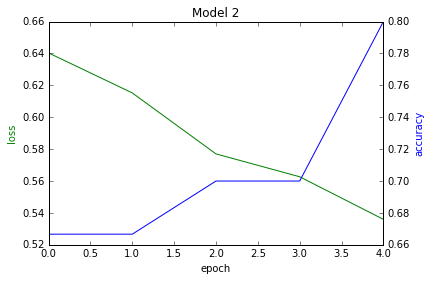

In [38]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History2.history['val_loss'])
ax1.plot(range(LN),History2.history['val_loss'],'g-')
ax2.plot(range(LN),History2.history['val_acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 2')